# Supply Chain Freight Cost Analysis

## Project Overview
This Jupyter notebook analyzes the freight costs within the global supply chain management system using the SCMS dataset. The focus is on uncovering key factors that impact freight costs and predicting these costs using machine learning models.

## Dataset Description
The dataset includes shipping details such as shipment mode, freight cost, item value, and other related features from global supply chain operations.


In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [49]:
%matplotlib inline
# Load the data
data = pd.read_csv('SCMS_Delivery_History_Dataset_20150929.csv', encoding='ISO-8859-1')

## Data Loading and Cleaning

Here, we load the dataset and perform initial preprocessing to clean the data, which includes filling missing values and correcting data formats.


In [50]:
# Data cleaning
# Safely fill missing values without using inplace in a chained assignment
data['Shipment Mode'] = data['Shipment Mode'].fillna(data['Shipment Mode'].mode()[0])
data['Freight Cost (USD)'] = pd.to_numeric(data['Freight Cost (USD)'], errors='coerce')
data['Freight Cost (USD)'] = data['Freight Cost (USD)'].fillna(data['Freight Cost (USD)'].median())

In [51]:

# Convert date columns to datetime
date_columns = ['PQ First Sent to Client Date', 'PO Sent to Vendor Date', 'Scheduled Delivery Date', 'Delivered to Client Date', 'Delivery Recorded Date']
for date_col in date_columns:
    data[date_col] = pd.to_datetime(data[date_col], errors='coerce', format='%d-%b-%y')

for date_col in date_columns:
    # Check if there's at least one non-NaN value
    if data[date_col].notna().any():
        median_date = data[date_col].median()
        data[date_col] = data[date_col].fillna(median_date)
    else:
        # If all values are NaN, perhaps fill with a placeholder date or skip
        placeholder_date = pd.Timestamp("today")
        data[date_col] = data[date_col].fillna(placeholder_date)

# Calculate delivery times as a new feature
data['Delivery Time'] = (data['Delivered to Client Date'] - data['Scheduled Delivery Date']).dt.days
data['Delivery Time'] = data['Delivery Time'].fillna(data['Delivery Time'].median())




## Descriptive Statistics

The following tables and figures provide a statistical summary of the numerical and categorical features within the dataset. This helps in understanding the distribution, count, and presence of outliers in the data.


In [52]:
# Displaying descriptive statistics
display(data.describe())


,ID,PQ First Sent to Client Date,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Freight Cost (USD),Line Item Insurance (USD),Delivery Time
count,10324.000000,10324,10324,10324,10324,10324,10324.000000,10324.000000,1.032400e+04,10324.000000,10324.000000,10324.000000,10037.000000,10324.000000
mean,51098.968229,2024-04-26 14:10:50.826698496,2024-04-26 14:10:50.826698496,2011-10-04 15:30:28.593568512,2011-09-28 14:56:34.963192576,2011-10-01 12:33:28.523827968,77.990895,18332.534870,1.576506e+05,21.910241,0.611701,9011.627852,240.117626,-6.023537
min,1.000000,2024-04-26 14:10:50.826698,2024-04-26 14:10:50.826698,2006-05-02 00:00:00,2006-05-02 00:00:00,2006-05-02 00:00:00,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.750000,0.000000,-372.000000
25%,12795.750000,2024-04-26 14:10:50.826697984,2024-04-26 14:10:50.826697984,2009-09-08 00:00:00,2009-09-01 00:00:00,2009-09-01 00:00:00,30.000000,408.000000,4.314593e+03,4.120000,0.080000,4323.807500,6.510000,-3.000000
50%,57540.500000,2024-04-26 14:10:50.826697984,2024-04-26 14:10:50.826697984,2011-12-05 00:00:00,2011-11-25 00:00:00,2011-11-25 00:00:00,60.000000,3000.000000,3.047147e+04,9.300000,0.160000,5869.655000,47.040000,0.000000
75%,83648.250000,2024-04-26 14:10:50.826697984,2024-04-26 14:10:50.826697984,2013-12-23 00:00:00,2013-12-23 00:00:00,2014-01-13 00:00:00,90.000000,17039.750000,1.664471e+05,23.592500,0.470000,7707.640000,252.400000,0.000000
max,86823.000000,2024-04-26 14:10:50.826698,2024-04-26 14:10:50.826698,2015-12-31 00:00:00,2015-09-14 00:00:00,2015-09-14 00:00:00,1000.000000,619999.000000,5.951990e+06,1345.640000,238.650000,289653.200000,7708.440000,192.000000
std,31944.332496,NaN,NaN,NaN,NaN,NaN,76.579764,40035.302961,3.452921e+05,45.609223,3.275808,12517.228517,500.190568,27.233640


## Data Visualization

Visualizations to explore the relationships between different features and the target variable (Freight Cost). These plots help in understanding the distributions and potential correlations.


### Histogram of Freight Costs
This histogram shows the distribution of freight costs across all shipments. The graph helps identify the range and skewness of freight costs, which can indicate common cost ranges and outliers. A KDE (Kernel Density Estimate) overlay provides a smooth estimate of the distribution, highlighting the central tendency and variability of freight costs.

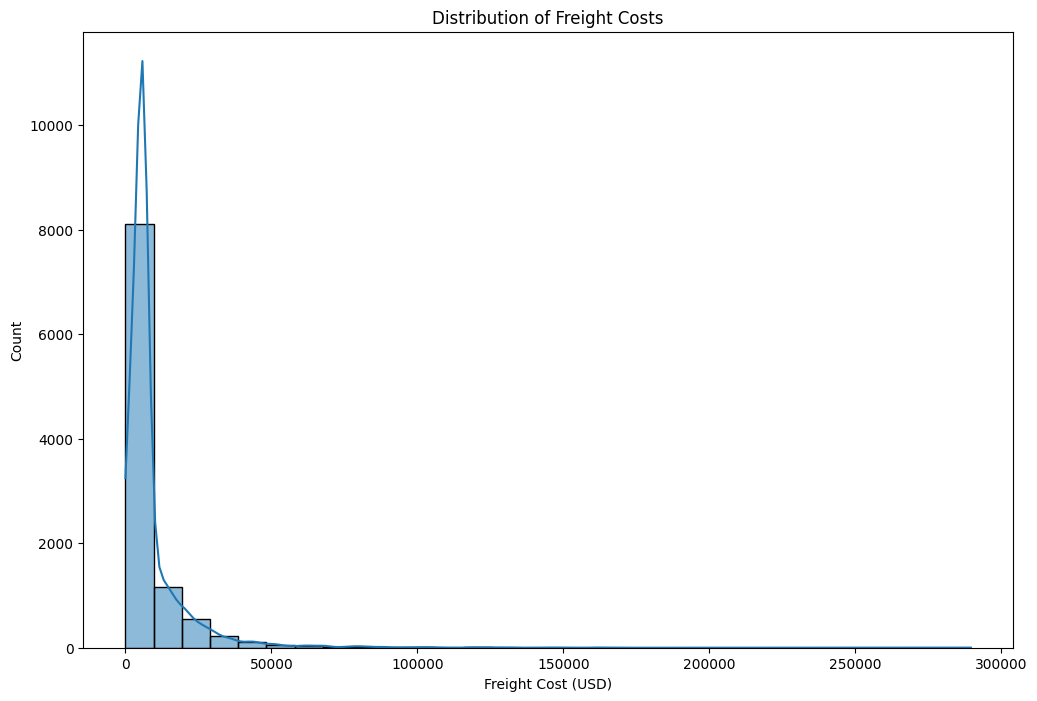

In [53]:

plt.figure(figsize=(12, 8))
sns.histplot(data['Freight Cost (USD)'], bins=30, kde=True)
plt.title('Distribution of Freight Costs')
plt.show()

### Scatter Plot of Line Item Value vs. Freight Cost
This scatter plot explores the relationship between the line item value and the freight cost. By plotting these two variables against each other, we can investigate whether a higher item value correlates with increased freight costs, which could be essential for cost management and budgeting in supply chain operations.


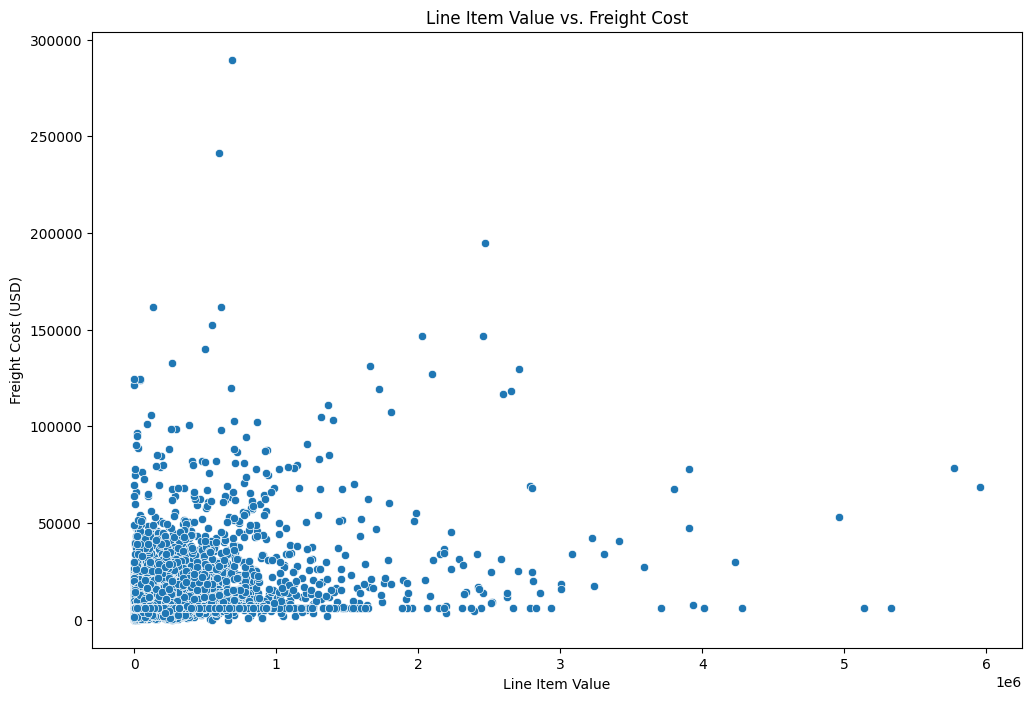

In [54]:

plt.figure(figsize=(12, 8))
sns.scatterplot(x='Line Item Value', y='Freight Cost (USD)', data=data)
plt.title('Line Item Value vs. Freight Cost')
plt.show()

### Shipping Volume by Country
The bar chart displays the number of shipments going to each country, ranked by volume. This visualization is crucial for understanding which countries have the highest demand and analyzing the geographical distribution of the supply chain's reach. It helps in strategic planning for logistics and market penetration.


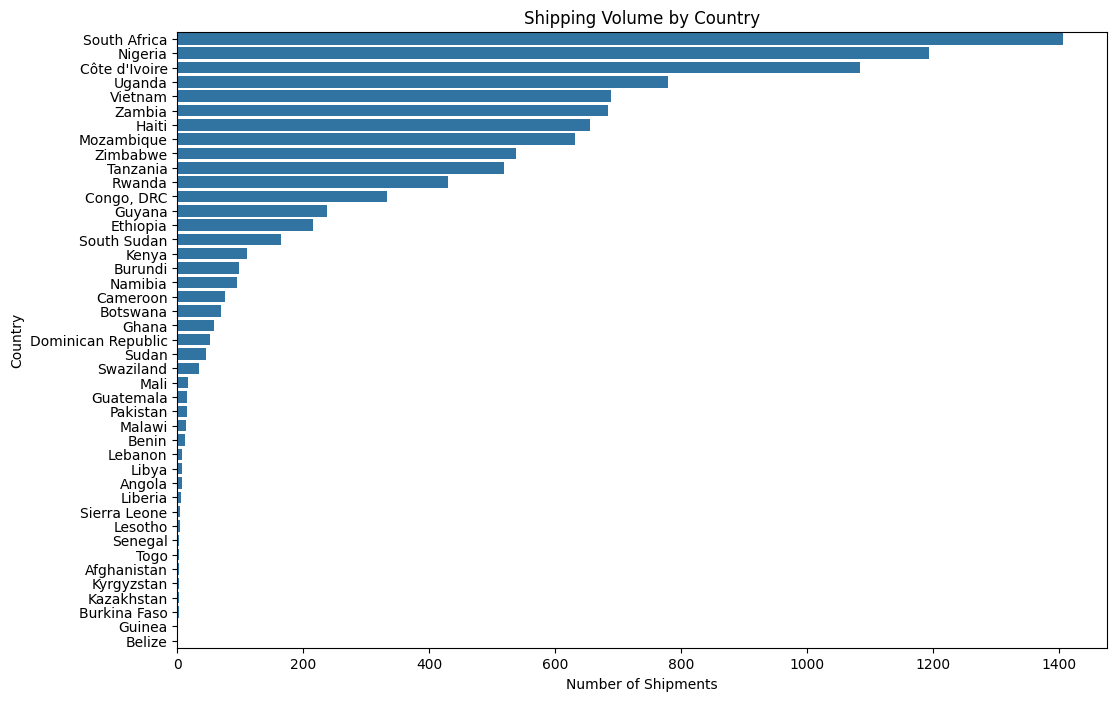

In [55]:

plt.figure(figsize=(12, 8))
sns.countplot(y='Country', data=data, order = data['Country'].value_counts().index)
plt.title('Shipping Volume by Country')
plt.xlabel('Number of Shipments')
plt.ylabel('Country')
plt.show()


### Freight Cost Distribution by Shipment Mode (Excluding Outliers)
This box plot illustrates the distribution of freight costs across different shipment modes while excluding outliers for a cleaner view. Such visualizations can aid in understanding how different transportation methods impact costs and can help in making decisions about the most cost-effective modes of shipment.


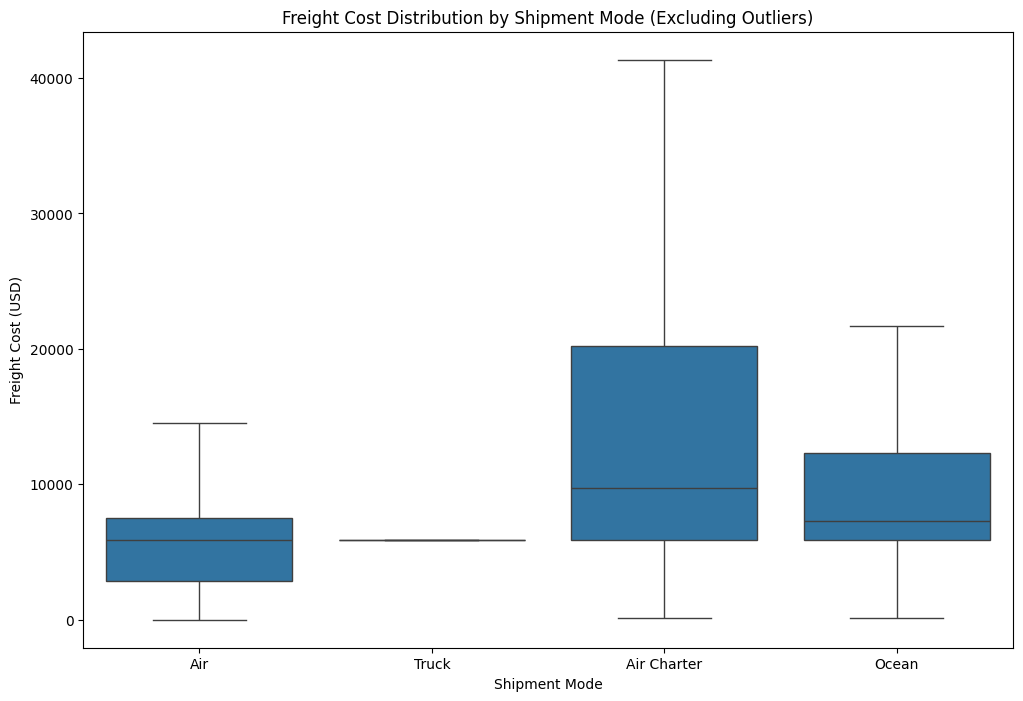

In [56]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Shipment Mode', y='Freight Cost (USD)', data=data, showfliers=False)
plt.title('Freight Cost Distribution by Shipment Mode (Excluding Outliers)')
plt.xlabel('Shipment Mode')
plt.ylabel('Freight Cost (USD)')
plt.show()

### Freight Cost vs. Delivery Time
This scatter plot examines the relationship between delivery time and freight costs. It's crucial for identifying trends such as whether longer delivery times correlate with higher freight costs, which can be pivotal for optimizing logistics strategies.


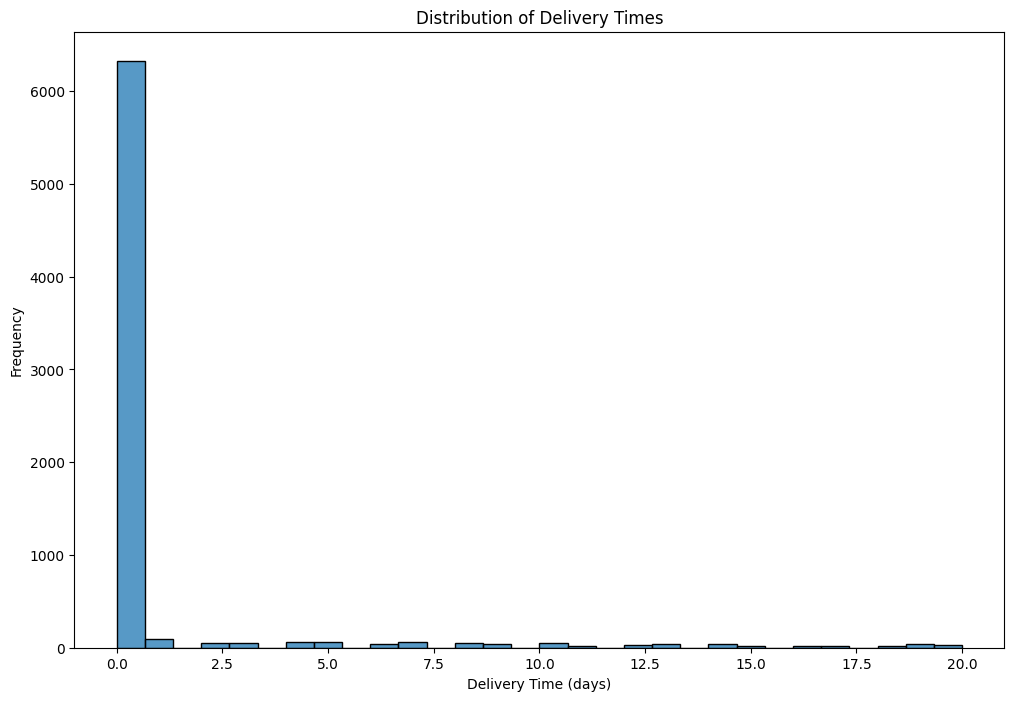

In [57]:
data['Scheduled Delivery Date'] = pd.to_datetime(data['Scheduled Delivery Date'], errors='coerce')
data['Delivered to Client Date'] = pd.to_datetime(data['Delivered to Client Date'], errors='coerce')
data['Delivery Time'] = (data['Delivered to Client Date'] - data['Scheduled Delivery Date']).dt.days

# Remove or correct negative delivery times
data = data[data['Delivery Time'] >= 0]

delivery_time_95th = data['Delivery Time'].quantile(0.95)

plt.figure(figsize=(12, 8))
sns.histplot(data[data['Delivery Time'] <= delivery_time_95th]['Delivery Time'], bins=30, kde=False)
plt.title('Distribution of Delivery Times')
plt.xlabel('Delivery Time (days)')
plt.ylabel('Frequency')
plt.show()


### Yearly Trends in Total Line Item Value
This line chart illustrates the total line item value over the years, providing insights into the growth or decline in the value of goods shipped per year. This can be an indicator of business growth, market expansion, or changes in procurement strategy.


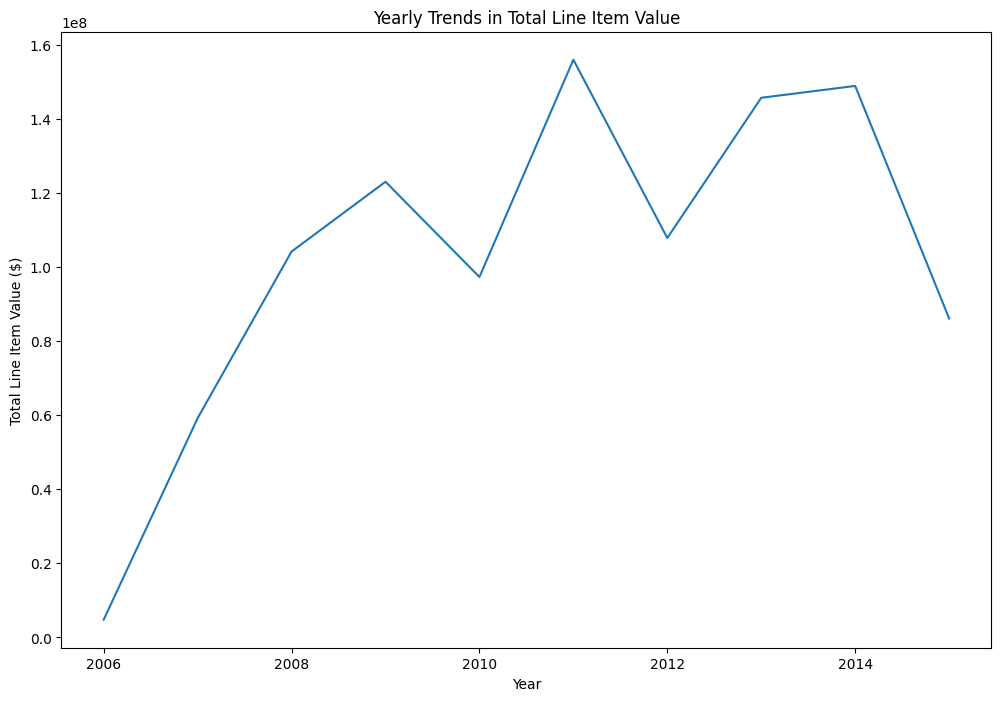

In [58]:

freight_cost_95th = data['Freight Cost (USD)'].quantile(0.95)

# Filter data based on both Delivery Time and Freight Cost
filtered_data = data[(data['Delivery Time'] <= delivery_time_95th) & (data['Freight Cost (USD)'] <= freight_cost_95th)]

data['Year'] = data['Scheduled Delivery Date'].dt.year
yearly_data = data.groupby('Year')['Line Item Value'].sum().reset_index()

plt.figure(figsize=(12, 8))
sns.lineplot(x='Year', y='Line Item Value', data=yearly_data)
plt.title('Yearly Trends in Total Line Item Value')
plt.xlabel('Year')
plt.ylabel('Total Line Item Value ($)')
plt.show()

## Predictive Modeling

Building a model to predict the freight costs based on features like 'Line Item Value' and 'Weight (Kilograms)'. We use a linear regression model as a starting point.


In [59]:
# Handle missing values without using inplace=True
data['Shipment Mode'] = data['Shipment Mode'].fillna(data['Shipment Mode'].mode()[0])
data['Freight Cost (USD)'] = pd.to_numeric(data['Freight Cost (USD)'], errors='coerce')
data['Freight Cost (USD)'] = data['Freight Cost (USD)'].fillna(data['Freight Cost (USD)'].median())

data['Weight (Kilograms)'] = pd.to_numeric(data['Weight (Kilograms)'], errors='coerce')
data['Weight (Kilograms)'] = data['Weight (Kilograms)'].fillna(data['Weight (Kilograms)'].median())

# Ensure there are no missing values in the features
X = data[['Line Item Value', 'Weight (Kilograms)']].fillna(0)
y = data['Freight Cost (USD)'].fillna(0)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = LinearRegression()
model.fit(X_train, y_train)

# Model prediction
y_pred = model.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)


Mean Squared Error: 144783426.1123695
R^2 Score: 0.15928700555125752


## Conclusion and Future Work

In this notebook, we explored various factors that impact freight costs in supply chain operations. The initial model provides a baseline for future improvements. Going forward, additional features can be engineered, and more complex models like Random Forest or Gradient Boosting could be employed to improve prediction accuracy.  Thank you for taking a look at my Supply Chain Data Analysis Project!

